# Proyecto Home Credit Risk

**Integrantes:**
- Martin Abel Reyes Rojas.

# 1. Entendimiento del Negocio

El objetivo de este concurso es predecir qué clientes tienen más probabilidades de impagar sus préstamos. La evaluación favorecerá las soluciones estables en el tiempo.
Su participación puede ofrecer a los proveedores de financiación al consumo una forma más fiable y duradera de evaluar el riesgo de impago de un cliente potencial.

# 2. Importar Liberias

In [1]:
# Esta librería la he utilizado la he utilizado para traducir a mi idioma algunos conceptos, pero la competencia no me
# permite utilizar librería de tercero pero la deja comentada por si alguien le interesa utilizarla y entender
# más rápido los conceptos en el idioma nativo de cad persona.
# from deep_translator import GoogleTranslator 

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

seed = 1234

In [2]:
# Traducir a mi idioma nativo -> Lo utilice para traducir y poder trabjar de una mejor manera con el entendimiento de cada columna.
# Creo una instancia para traducir a mi idioma nativo.
# gs = GoogleTranslator(source= 'english', target= 'spanish')

# 3. Cargar Data

In [3]:
# Ruta para acceder a todos los datasets.
dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"

## 3.1. Cargar la Definición de las Feature
Entender mejor el significado de cada columna con el fin de tener mejor comprensión del significado de la data.

In [4]:
df_feature = pl.read_csv(dataPath + 'feature_definitions.csv')

In [5]:
df_feature.shape

(465, 2)

## 3.2. Funciones

In [6]:
# Convertir los tipos de datos de las columnas.
def set_columns_dtypes(df: pl.DataFrame):    
    for col in df.columns:        
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64))

    return df

In [7]:
# Reemplazar las columnas con su descripción para un mejor entendimiento.
def replace_columns(df):
    dict_col = {}
    for i in range(len(df.columns)):
        description = df_feature.filter(pl.col('Variable') == df.columns[i])['Description']    
        if description.shape[0] == 1:                
            dict_col[df.columns[i]] = f'{i}_{description[0]}'
    
    return df.rename(dict_col)

In [8]:
# Función para mostrar las columnas con su respectivo tipo.
def type_cols(df):
    return pl.dataframe.DataFrame({'columns': df.columns, 'dtypes': df.dtypes})

In [9]:
# Función para mostrar los hallazgos más relevantes con respecto al target y las categorías.
def categorical_finding(X, colsNameCategoricas):    
    for colName in colsNameCategoricas:        
        display(X[[colName, 'target']].groupby(colName).agg(['count', 'sum', 'mean']))

## 3.3. Cargar los Datos de Forma Entendible

In [10]:
# Cargar datos de train.
df_tr_base = pl.read_csv(dataPath + 'csv_files/train/train_base.csv')

# Cargar datos de static_0.
df_tr_static_0 = pl.concat([
    pl.read_csv(dataPath + 'csv_files/train/train_static_0_0.csv').pipe(set_columns_dtypes), # La función es similar al apply.
    pl.read_csv(dataPath + 'csv_files/train/train_static_0_1.csv').pipe(set_columns_dtypes)
], how= 'vertical_relaxed').pipe(replace_columns)

# Cargar datos de applprev_1.
df_tr_applprev_1 = pl.concat([
    pl.read_csv(dataPath + 'csv_files/train/train_applprev_1_0.csv').pipe(set_columns_dtypes),
    pl.read_csv(dataPath + 'csv_files/train/train_applprev_1_1.csv').pipe(set_columns_dtypes)
], how= 'vertical_relaxed').pipe(replace_columns)

# Cargar datos de person_1.
df_tr_person_1 = pl.read_csv(dataPath + 'csv_files/train/train_person_1.csv').pipe(set_columns_dtypes).pipe(replace_columns)

In [11]:
# Mostrar la cantidad que registros que tiene cada dataframe que voy a utilizar.
len(df_tr_base.columns), len(df_tr_static_0.columns), len(df_tr_applprev_1.columns), len(df_tr_person_1.columns)

(5, 168, 41, 37)

In [12]:
# Cargar datos de test.
df_ts_base = pl.read_csv(dataPath + 'csv_files/test/test_base.csv')

df_ts_static_0 = pl.concat([
    pl.read_csv(dataPath + 'csv_files/test/test_static_0_0.csv').pipe(set_columns_dtypes),
    pl.read_csv(dataPath + 'csv_files/test/test_static_0_1.csv').pipe(set_columns_dtypes),
    pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_columns_dtypes)
], how= 'vertical_relaxed').pipe(replace_columns)

df_ts_applprev_1 = pl.concat([
    pl.read_csv(dataPath + 'csv_files/test/test_applprev_1_0.csv').pipe(set_columns_dtypes),
    pl.read_csv(dataPath + 'csv_files/test/test_applprev_1_1.csv').pipe(set_columns_dtypes)
], how= 'vertical_relaxed').pipe(replace_columns)

df_ts_person_1 = pl.read_csv(dataPath + 'csv_files/test/test_person_1.csv').pipe(set_columns_dtypes).pipe(replace_columns)

In [13]:
# Mostrar la cantidad que registros que tiene cada dataframe de test que voy a utilizar.
len(df_ts_base.columns), len(df_ts_static_0.columns), len(df_ts_applprev_1.columns), len(df_ts_person_1.columns)

(4, 168, 41, 37)

In [14]:
# X_p: X previous -> Nos quedamos con variables independientes del dataframe para separarlo de la dependiente o target.
X_p = df_tr_base.select(df_tr_base.columns[:-1])

In [15]:
# Test.
X_pts = df_ts_base

In [16]:
# Nos quedamos con el target y el case_id.
y = df_tr_base.select(pl.col(['case_id', 'target']))

## 3.4. Features Finales 

### *3.4.1. df_tr_static_0*

In [17]:
# Variables que yo considero que son importantes de la data static 0.
variables_static_0 = [
    '166_Persons accompanying the client during the loan application process.',
    '167_Date since the client has an active campaign.'
]

In [18]:
# Observamos que no hay repetidos ya que tiene una profundidad de 0.
len(df_tr_static_0), df_tr_static_0.select(pl.col('case_id')).n_unique()

(1526659, 1526659)

In [19]:
# Gurdarmos el dataframe en un variable con las columnas más importantes.
df_mtr_static_0 = df_tr_static_0.select([pl.selectors.numeric(), pl.col(variables_static_0)])

In [20]:
# Test.
df_mts_static_0 = df_ts_static_0.select(df_mtr_static_0.columns).with_columns(
    pl.col('38_Number of incoming payments in the past 9 months.').cast(pl.Float64)
)

### 3.4.2. *df_tr_applprev_1*

In [21]:
# Variables que yo considero importantes de la data applprev 1.
variables_applprev_1 = [
    '7_Date when previous application was created.',
    "22_Applicant's education level from their previous application.",
    '24_Family State in previous application of applicant.',
    '26_Type of the initial transaction made in the previous application of the client.'
]

In [22]:
# Observamos que hay repetidos ya que tiene una profundidad de 1.
len(df_tr_applprev_1), df_tr_applprev_1.select(pl.col('case_id')).n_unique()

(6525979, 1221522)

In [23]:
# Test.
df_mts_applprev_1 = df_ts_applprev_1.with_columns(pl.col('6_Number of children in the previous application.').cast(pl.Float64)).select([pl.selectors.numeric(), pl.col(variables_applprev_1)]).group_by(['case_id'], maintain_order= True).agg(
    pl.selectors.numeric().sum().name.suffix('_total'), # Realizamos una suma para las variables float.
    pl.selectors.string().filter(pl.col('num_group1') == 0).max() # Nos quedamos con la última información acerca del cliente.
)

In [24]:
# Gurdarmos el dataframe en un variable con las columnas más importantes.
df_mtr_applprev_1 = df_tr_applprev_1.select([pl.selectors.numeric(), pl.col(variables_applprev_1)]).select(pl.exclude('13_Number of transactions made with the previous credit account of the applicant.')).group_by(['case_id'], maintain_order= True).agg(
    pl.selectors.numeric().sum().name.suffix('_total'), # Realizamos una suma para las variables float.
    pl.selectors.string().filter(pl.col('num_group1') == 0).max() # Nos quedamos con la última información acerca del cliente.
)

In [25]:
# Observamos que hay repetidos ya que tiene una profundidad de 1.
len(df_mtr_applprev_1), df_mtr_applprev_1.select(pl.col('case_id')).n_unique()

(1221522, 1221522)

### *3.4.3. df_tr_person_1*

In [26]:
variables_person_1 = [
    '8_Education level of the person.',
    '9_Start date of employment.',
    '10_Employment length of a person.',
    '11_Employment Industry of the person.',
    "12_District where the employer's address is located.",
    '14_Family state of the person.',
    '15_Gender of a person.',
    '16_House type of the person.',
    '17_Type of housing of the person.',
    '18_Type of income of the person',
    '20_The primary language of the person.',
    '22_Marital status of the client.',
    '29_Relationship to the client.',
    '30_Relationship to the client.',
    "33_Person's role."
]

In [27]:
df_mtr_person_1 = df_tr_person_1.select([pl.selectors.numeric(), pl.col(variables_person_1)]).group_by('case_id').agg(
    pl.selectors.numeric().sum(),
    pl.selectors.string().filter(pl.col('num_group1') == 0).max() # Nos quedamos con la última acerca información del cliente.
) 

In [28]:
# Test
df_mts_person_1 = df_ts_person_1.select(pl.col(df_mtr_person_1.columns)).group_by('case_id').agg(
    pl.selectors.numeric().sum(),
    pl.selectors.string().filter(pl.col('num_group1') == 0).max() # Nos quedamos con la última acerca información del cliente.
) 

In [29]:
# Observamos que ya no hay repetidos.
len(df_mtr_person_1), df_mtr_person_1.select(pl.col('case_id')).n_unique()

(1526659, 1526659)

### *3.4.4. df_tr_credit_br_b_2*

In [30]:
# Unir todas las columnas que se relacionan con el X base.
X = X_p.join(df_mtr_static_0, how= 'left', on= 'case_id').join(
    df_mtr_applprev_1, how= 'left', on= 'case_id').join(
    df_mtr_person_1, how= 'left', on= 'case_id'
)

In [31]:
# Test.
X_ts = X_pts.join(df_mts_static_0, how= 'left', on= 'case_id').join(
    df_mts_applprev_1, how= 'left', on= 'case_id').join(
    df_mts_person_1, how= 'left', on= 'case_id'
)

In [32]:
# Features finales aunque se puede agregar las demás.
X

case_id,date_decision,MONTH,WEEK_NUM,1_DPD of client with tolerance.,2_Number of instalments paid before due date in the last 24 months.,3_Monthly annuity amount.,4_Next month's amount of annuity.,5_Number of applications associated with the same email address as the client.,6_Number of applications made by the client in the last 30 days.,7_Number of applications associated with the same phone number.,8_Number of applications made in the last 30 days by other clients with the same employer as the applicant.,9_Number of applications with the same employer in the last 7 days.,10_Number of applications associated with the same mobile phone.,11_Average days past or before due of payment during the last 24 months.,12_Average days past or before due of payment during the last 3 months.,13_Average days of payment before due date within the last 24 months (with tolerance).,"14_Average DPD (days past due) with tolerance within the past 24 months from the maximum closure date, assuming that the contract is finished. If the contract is ongoing, the calculation is based on the current date.",15_Average instalments paid by the client over the past 24 months.,16_Average loan amount in the last 24 months.,17_Average Days Past Due (DPD) of the client in last 9 months.,18_Average outstanding balance of applicant for the last 6 months.,19_Average of payments made by the client in the last 12 months.,22_Number of clients that have used the same mobile phone as the applicant in the past 12 months.,23_Number of clients who have the same mobile phone number in the last 3 months.,24_Total number of clients who have used the same mobile number in the last 6 months.,25_Number of applications with matching employer's phone and client's.,26_Number of clients sharing the same mobile phone.,27_Number of applications where the alternative phone number matches that of the client.,28_Number of applications where client's phone number matches the alternative phone contact.,30_Number of clients whose employer has the same phone number as the client.,31_Number of clients that share an alternative phone number with the applicant.,32_Number of clients with the same phone number.,33_Number of clients that have the same alternative phone number and employer's phone number.,34_Number of clients with matching phone numbers for both the employer and the client.,35_Number of clients with same client's and alternative's phone number,36_Number of clients sharing the same employer's phone number.,…,10_Maximal historical balance of previous credit account_total,11_Minimum historical balance of previous credit accounts._total,14_Loan amount or card limit of previous applications._total,16_Previous application's current debt._total,19_Previous application downpayment amount._total,29_Client's main income amount in their previous application._total,30_Maximum DPD with tolerance (on previous application/s)._total,num_group1_total,32_Amount of outstanding debt on the client's previous application._total,33_Number of payments made for the previous application._total,38_Revolving account that was present in the applicant's previous application._total,40_Number of instalments in the previous application._total,7_Date when previous application was created.,22_Applicant's education level from their previous application.,24_Family State in previous application of applicant.,26_Type of the initial transaction made in the previous application of the client.,3_Number of children of the applicant.,21_Amount of the main income of the client.,num_group1,24_Order of the person specified on the application form.,25_Person type.,26_Person type.,8_Education level of the person.,9_Start date of employment.,10_Employment length of a person.,11_Employment Industry of the person.,12_District where the employer's address is located.,14_Family state of the person.,15_Gender of a person.,16_House type of the person.,17_Type of housing of the person.,18_Type of income of the person,20_The primary lang

# 4. Análisis Exploratorio de los Datos (EDA)

## 4.1. Manipulación de los Datos

In [33]:
# Mostramos los 5 primeros registros.
X.head(5)

case_id,date_decision,MONTH,WEEK_NUM,1_DPD of client with tolerance.,2_Number of instalments paid before due date in the last 24 months.,3_Monthly annuity amount.,4_Next month's amount of annuity.,5_Number of applications associated with the same email address as the client.,6_Number of applications made by the client in the last 30 days.,7_Number of applications associated with the same phone number.,8_Number of applications made in the last 30 days by other clients with the same employer as the applicant.,9_Number of applications with the same employer in the last 7 days.,10_Number of applications associated with the same mobile phone.,11_Average days past or before due of payment during the last 24 months.,12_Average days past or before due of payment during the last 3 months.,13_Average days of payment before due date within the last 24 months (with tolerance).,"14_Average DPD (days past due) with tolerance within the past 24 months from the maximum closure date, assuming that the contract is finished. If the contract is ongoing, the calculation is based on the current date.",15_Average instalments paid by the client over the past 24 months.,16_Average loan amount in the last 24 months.,17_Average Days Past Due (DPD) of the client in last 9 months.,18_Average outstanding balance of applicant for the last 6 months.,19_Average of payments made by the client in the last 12 months.,22_Number of clients that have used the same mobile phone as the applicant in the past 12 months.,23_Number of clients who have the same mobile phone number in the last 3 months.,24_Total number of clients who have used the same mobile number in the last 6 months.,25_Number of applications with matching employer's phone and client's.,26_Number of clients sharing the same mobile phone.,27_Number of applications where the alternative phone number matches that of the client.,28_Number of applications where client's phone number matches the alternative phone contact.,30_Number of clients whose employer has the same phone number as the client.,31_Number of clients that share an alternative phone number with the applicant.,32_Number of clients with the same phone number.,33_Number of clients that have the same alternative phone number and employer's phone number.,34_Number of clients with matching phone numbers for both the employer and the client.,35_Number of clients with same client's and alternative's phone number,36_Number of clients sharing the same employer's phone number.,…,10_Maximal historical balance of previous credit account_total,11_Minimum historical balance of previous credit accounts._total,14_Loan amount or card limit of previous applications._total,16_Previous application's current debt._total,19_Previous application downpayment amount._total,29_Client's main income amount in their previous application._total,30_Maximum DPD with tolerance (on previous application/s)._total,num_group1_total,32_Amount of outstanding debt on the client's previous application._total,33_Number of payments made for the previous application._total,38_Revolving account that was present in the applicant's previous application._total,40_Number of instalments in the previous application._total,7_Date when previous application was created.,22_Applicant's education level from their previous application.,24_Family State in previous application of applicant.,26_Type of the initial transaction made in the previous application of the client.,3_Number of children of the applicant.,21_Amount of the main income of the client.,num_group1,24_Order of the person specified on the application form.,25_Person type.,26_Person type.,8_Education level of the person.,9_Start date of employment.,10_Employment length of a person.,11_Employment Industry of the person.,12_District where the employer's address is located.,14_Family state of the person.,15_Gender of a person.,16_House type of the person.,17_Type of housing of the person.,18_Type of income of the person,20_The primary lang

***Diccionario de Datos***
case_id: Identificador único para cada caso o solicitud.

* ***date_decision:*** Fecha en que se tomó la decisión sobre la solicitud.

* ***MONTH:*** Mes en que se realizó la solicitud.

* ***WEEK_NUM:*** Número de semana en que se realizó la solicitud.

* ***1_DPD del cliente con tolerancia.: Número de días vencidos del cliente con tolerancia.

* ***2_Número de cuotas pagadas antes del vencimiento en los últimos 24 meses.:*** Cantidad de cuotas pagadas antes del vencimiento en los últimos 24 meses.

* ***3_Monto de la anualidad mensual.:*** Monto de la anualidad mensual del préstamo.

* ***5_Número de aplicaciones asociadas a la misma dirección de correo electrónico que el cliente.:*** Número de aplicaciones asociadas a la misma dirección de correo electrónico del cliente.

* ***6_Número de solicitudes realizadas por el cliente en los últimos 30 días.:*** Cantidad de solicitudes realizadas por el cliente en los últimos 30 días.

* ***7_Número de aplicaciones asociadas a un mismo número de teléfono.:*** Número de aplicaciones asociadas a un mismo número de teléfono.

* ***10_Número de aplicaciones asociadas a un mismo teléfono móvil.:*** Número de aplicaciones asociadas a un mismo teléfono móvil.

* ***11_Promedio de días vencidos o vencidos de pago durante los últimos 24 meses.:*** Promedio de días vencidos o vencidos de pago durante los últimos 24 meses.

* ***12_Promedio de días vencidos o vencidos de pago durante los últimos 3 meses.:*** Promedio de días vencidos o vencidos de pago durante los últimos 3 meses.

* ***15_Cuotas medias pagadas por el cliente en los últimos 24 meses.:*** Cuotas medias pagadas por el cliente en los últimos 24 meses.

* ***17_Promedio de Días Vencidos (DPD) del cliente en los últimos 9 meses.:*** Promedio de días vencidos del cliente en los últimos 9 meses.

* ***19_Promedio de pagos realizados por el cliente en los últimos 12 meses.:*** Promedio de pagos realizados por el cliente en los últimos 12 meses.

* ***25_Número de solicitudes que coinciden con el teléfono del empleador y el del cliente.:*** Número de solicitudes que coinciden con el teléfono del empleador y el del cliente.

* ***33_Número de clientes que tienen el mismo número de teléfono alternativo y número de teléfono del empleador.:*** Número de clientes que tienen el mismo número de teléfono alternativo y número de teléfono del empleador.

* ***38_Número de pagos recibidos en los últimos 9 meses.:*** Número de pagos recibidos en los últimos 9 meses.

* ***41_Monto del préstamo o límite de la tarjeta de crédito.:*** Monto del préstamo o límite de la tarjeta de crédito.

* ***43_Monto de deuda actual del cliente.:*** Monto de deuda actual del cliente.

* ***44_Monto actual de la deuda del solicitante.:*** Monto actual de la deuda del solicitante.

* ***50_Monto del crédito desembolsado después de la consolidación.:*** Monto del crédito desembolsado después de la consolidación.

* ***54_Tasa de interés.:*** Tasa de interés.

* ***71_Monto del crédito de la última solicitud del cliente.:*** Monto del crédito de la última solicitud del cliente.

* ***77_Gastos mensuales de otros préstamos desde la última solicitud.:*** Gastos mensuales de otros préstamos desde la última solicitud.

* ***86_Monto del ingreso principal del cliente.:*** Monto del ingreso principal del cliente.

* ***97_Número de cuota cuyo cliente tenía más días de mora.:*** Número de cuota en la que el cliente tenía más días de mora.

* ***152_Número total de pagos de préstamo realizados por el cliente.:*** Número total de pagos de préstamo realizados por el cliente.

* ***157_Precio del crédito.:*** Precio del crédito.

* ***166_Personas que acompañan al cliente durante el proceso de solicitud del préstamo.:*** Personas que acompañan al cliente durante el proceso de solicitud del préstamo.

* ***167_Fecha desde que el cliente tiene una campaña activa.:*** Fecha desde que el cliente tiene una campaña activa.

* ***1_Días Vencidos (DPD) del contrato anterior (reales)._total:*** Días vencidos (DPD) del contrato anterior (reales).

* ***2_Anualidad mensual para solicitudes anteriores._total:*** Anualidad mensual para solicitudes anteriores.

* ***4_Ingresos del solicitante de solicitudes anteriores._total:*** Ingresos del solicitante de solicitudes anteriores.

* ***6_Número de hijos en la solicitud anterior._total:*** Número de hijos en la solicitud anterior.

* ***8_Saldo real en cuenta de crédito._total:*** Saldo real en cuenta de crédito.

* ***9_Límite de crédito de tarjeta de crédito previsto para solicitudes anteriores._total:*** Límite de crédito de tarjeta de crédito previsto para solicitudes anteriores.

* ***10_Saldo histórico máximo de la cuenta de crédito anterior_total:*** Saldo histórico máximo de la cuenta de crédito anterior.

* ***11_Saldo histórico mínimo de cuentas de crédito anteriores._total:*** Saldo histórico mínimo de cuentas de crédito anteriores.

* ***13_Número de transacciones realizadas con la cuenta de crédito anterior del solicitante._total:*** Número de transacciones realizadas con la cuenta de crédito anterior del solicitante.

* ***14_Importe del préstamo o límite de la tarjeta de solicitudes anteriores._total:*** Importe del préstamo o límite de la tarjeta de solicitudes anteriores.

* ***16_Deuda actual de la solicitud anterior._total:*** Deuda actual de la solicitud anterior.

* ***29_Monto de ingresos principales del cliente en su solicitud anterior._total:*** Monto de ingresos principales del cliente en su solicitud anterior.

* ***30_DPD máximo con tolerancia (en aplicaciones anteriores)._total:*** DPD máximo con tolerancia (en aplicaciones anteriores).

* ***32_Importe de la deuda pendiente en la solicitud anterior del cliente._total:*** Importe de la deuda pendiente en la solicitud anterior del cliente.

* ***33_Número de pagos realizados para la solicitud anterior._total:*** Número de pagos realizados para la solicitud anterior.

* ***22_Nivel educativo del solicitante desde su solicitud anterior.:*** Nivel educativo del solicitante desde su solicitud anterior.

* ***24_Estado familiar en solicitud anterior del solicitante.:*** Estado familiar en solicitud anterior del solicitante.

* ***26_Tipo de transacción inicial realizada en la solicitud anterior del cliente.:*** Tipo de transacción inicial realizada en la solicitud anterior del cliente.

* ***3_Número de hijos del solicitante.:*** Número de hijos del solicitante.

* ***21_Importe de los ingresos principales del cliente.:*** Importe de los ingresos principales del cliente.

* ***24_Orden de la persona especificada en el formulario de solicitud.:*** Orden de la persona especificada en el formulario de solicitud.

* ***25_Tipo de persona.:*** Tipo de persona.

* ***8_Nivel educativo de la persona.:*** Nivel educativo de la persona.

* ***9_Fecha de inicio del empleo.:*** Fecha de inicio del empleo.

* ***10_Duración del empleo de una persona.:*** Duración del empleo de una persona.

* ***11_Empleo Industria de la persona.:*** Empleo Industria de la persona.

* ***12_Distrito donde se encuentra el domicilio del empleador.:*** Distrito donde se encuentra el domicilio del empleador.

* ***14_Estado familiar de la persona.:*** Estado familiar de la persona.

* ***15_Género de una persona.:*** Género de una persona.

* ***16_Tipo de casa de la persona.:*** Tipo de casa de la persona.

* ***17_Tipo de vivienda de la persona.:*** Tipo de vivienda de la persona.

* ***18_Tipo de ingresos de la persona:*** Tipo de ingresos de la persona.

* ***20_El idioma principal de la persona.:*** El idioma principal de la persona.

* ***22_Estado civil del cliente.:*** Estado civil del cliente.

* ***29_Relación con el cliente.:*** Relación con el cliente.

* ***30_Relación con el cliente.:*** Relación con el cliente.

* ***33_El papel de la persona.:*** El papel de la persona.

In [34]:
X.shape

(1526659, 164)

**Hay más de 1 millón de registros de clientes y 71 característica de cada uno.**

In [35]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.

# Mostrar los tipos de cada columna.
# type_cols(X)

In [36]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.

# Observar los valores únicos por cada columna.
# X.select(pl.all().n_unique()).transpose(include_header= True).rename({'column': 'name_cols', 'column_0': 'cantidad_unica'})

## 4.2. Entendimiento de Datos

In [37]:
# Featues numéricas.
X.select(pl.selectors.numeric()).describe()[:, 0:20]

statistic,case_id,MONTH,WEEK_NUM,1_DPD of client with tolerance.,2_Number of instalments paid before due date in the last 24 months.,3_Monthly annuity amount.,4_Next month's amount of annuity.,5_Number of applications associated with the same email address as the client.,6_Number of applications made by the client in the last 30 days.,7_Number of applications associated with the same phone number.,8_Number of applications made in the last 30 days by other clients with the same employer as the applicant.,9_Number of applications with the same employer in the last 7 days.,10_Number of applications associated with the same mobile phone.,11_Average days past or before due of payment during the last 24 months.,12_Average days past or before due of payment during the last 3 months.,13_Average days of payment before due date within the last 24 months (with tolerance).,"14_Average DPD (days past due) with tolerance within the past 24 months from the maximum closure date, assuming that the contract is finished. If the contract is ongoing, the calculation is based on the current date.",15_Average instalments paid by the client over the past 24 months.,16_Average loan amount in the last 24 months.
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.526659e6,1.526659e6,1.526659e6,1.108481e6,965535.0,1.526659e6,1.526655e6,1.526659e6,1.526659e6,1.526659e6,1.526659e6,1.526659e6,1.526659e6,913457.0,578415.0,553832.0,1.059484e6,901784.0,162509.0
"""null_count""",0.0,0.0,0.0,418178.0,561124.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,613202.0,948244.0,972827.0,467175.0,624875.0,1.36415e6
"""mean""",1.2861e6,201936.287982,40.769036,0.079234,55958.330289,4039.207272,1435.775015,0.000022,0.138152,0.42451,1.073578,0.268713,2.88036,30.098977,29.494342,30.759373,45.809286,5401.587636,44717.566753
"""std""",718946.592285,44.735975,23.797981,11.206518,71614.166354,3006.607629,2807.021232,0.008134,0.488663,3.128111,9.715778,2.464199,4.346472,317.684627,367.273913,322.467403,318.540587,6531.562344,44844.78673
"""min""",0.0,201901.0,0.0,0.0,0.0,80.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1220.0,-908.0,-1220.0,0.0,0.0,0.0
"""25%""",766198.0,201906.0,23.0,0.0,7419.2,1967.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11.0,-11.0,-12.0,0.0,2528.4001,15682.601
"""50%""",1.357358e6,201910.0,40.0,0.0,29758.396,3151.8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-5.0,-4.0,-5.0,0.0,4068.6,28419.4
"""75%""",1.739023e6,202001.0,55.0,0.0,76303.086,5231.4,2029.4,0.0,0.0,0.0,0.0,0.0,4.0,-1.0,-1.0,-2.0,1.0,6551.8003,56334.2
"""max""",2.703454e6,202010.0,91.0,4206.0,1408010.2,106007.0,87500.0,5.0,28.0,728.0,247.0,90.0,287.0,4750.0,4750.0,4750.0,4750.0,496148.8,513520.0


In [38]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.

# # Features objects.
# display(X._to_pandas_with_object_columns(use_pyarrow_extension_array= False).describe(include= 'object').iloc[:,0:10])
# display(X._to_pandas_with_object_columns(use_pyarrow_extension_array= False).describe(include= 'object').iloc[:,10: len(X.columns)])

In [39]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.

# # Verificar la cantidad de nulos por columna y su porcentaje.
# for col in X.columns:
#     print(f"{col} - {X[col].null_count()} - {X[col].null_count() / len(X[col]) * 100} %")

In [40]:
# Librería para graficar los nulos.
# Esta comentnado porque la comptencia no permite la utilización de librerías de terceros.

# import missingno as msno

In [41]:
# Analizamos los valores nulos para las columnas str.
# Esta comentnado porque la comptencia no permite la utilización de librerías de terceros.

# msno.matrix(X.select(pl.selectors.string())._to_pandas_with_object_columns(use_pyarrow_extension_array= True))
# plt.show()

**Se observa que hay una gran cantidad de nulos en las con los siguientes números iniciales 167, 15, 16, 17, 22 y 33 que podría ser una opción eliminarlas y las otras realizarles una inputación.**

In [42]:
# Analizamos los valores nulos para las columnas numeric.
# Esta comentnado porque la comptencia no permite la utilización de librerías de terceros.

# msno.matrix(X.select(pl.selectors.numeric())._to_pandas_with_object_columns(use_pyarrow_extension_array= True).iloc[:,0:15])
# msno.matrix(X.select(pl.selectors.numeric())._to_pandas_with_object_columns(use_pyarrow_extension_array= True).iloc[:,15:25])
# msno.matrix(X.select(pl.selectors.numeric())._to_pandas_with_object_columns(use_pyarrow_extension_array= True).iloc[:,25:35])
# msno.matrix(X.select(pl.selectors.numeric())._to_pandas_with_object_columns(use_pyarrow_extension_array= True).iloc[:,35:49])
# plt.show()

**Se observa que hay una gran cantidad de nulos en columna 77_Gastos mensuales de otros préstamos desde la última solicitud que posiblemente sea eliminado.**

### *4.2.1. Analizando el Target: y (le dieron el prestamo si (1) o no (0))*

In [43]:
# Cambiamos el background de los gráficos.
plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth": 0.5, "grid.alpha": 0.5})

In [44]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.

# sns.countplot(data= y.to_pandas(), x= 'target')
# print(y['target'].to_pandas().value_counts(normalize= 1))
# plt.show()

**Se observa que 96% de los clientes no han recibio un préstamo y 4% de los clientes sí lo han recibido.**

### *4.2.2. Variables Cuantitativas*

In [45]:
X_numeric = X.select(pl.selectors.numeric())

In [46]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.
# Visaulizar un resumen estadístico.

# X_numeric.describe()

In [47]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.
# Esta linea de código esta comentado porque se demora un poco en la ejecución de todos las distribuciones numéricas.

# for i in range(0, 46, 5):
#     X_numeric.to_pandas()[X_numeric.columns[i: i + 5]].hist(bins= 50, figsize= (20, 15), color= 'skyblue')
# plt.show()

In [48]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.
# Esta linea de código esta comentado porque se demora un poco en la ejecución de un gráfico de la matriz de correlación.

# corr = X_numeric.with_columns(y).to_pandas()[X_numeric.columns + ['target']].corr()

# fig = plt.figure(figsize= (24,16))
# sns.heatmap(corr, annot= corr, fmt= '.1f', linewidth= 0.2, cmap= 'bwr')
# plt.show()

In [49]:
# Mostramos las variables que tienen mayor correlación en un gráfico.

# corr = X_numeric.with_columns(y).to_pandas()[X_numeric.columns + ['target']].corr()
# corr[['target']].sort_values(by= 'target', ascending= False).style.background_gradient()

### *4.2.3. Variables Categóricas*

In [50]:
X_categorical = X.select([pl.col('case_id'), pl.selectors.string()])

In [51]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.

# Imprimimos toda la información encontrada de las variables categóricas.

# categorical_finding(X_categorical.with_columns(y).to_pandas(), X_categorical.columns)

# 5. Tratamiento de Datos

## 5.1. Eliminar Columnas que no Aportan Valor Informativo

In [52]:
# Eliminar las columnas con más del 40% de nulos.
# Obtener las columnas numeric y string.
cols_numeric_mas_40 = []
cols_string_mas_40 = []

for col in X_numeric.columns:
    percent = X[col].null_count() / len(X[col]) * 100
    if percent >= 40:
        cols_numeric_mas_40.append(col)
        print(f"{col} - {X[col].null_count()} - {percent} %")
        
for col in X_categorical.columns:
    percent = X[col].null_count() / len(X[col]) * 100
    if percent >= 40:
        cols_string_mas_40.append(col)
        print(f"{col} - {X[col].null_count()} - {percent} %")

11_Average days past or before due of payment during the last 24 months. - 613202 - 40.16627157734634 %
12_Average days past or before due of payment during the last 3 months. - 948244 - 62.11236431973348 %
13_Average days of payment before due date within the last 24 months (with tolerance). - 972827 - 63.72261258080554 %
15_Average instalments paid by the client over the past 24 months. - 624875 - 40.93088240399461 %
16_Average loan amount in the last 24 months. - 1364150 - 89.35525222069892 %
17_Average Days Past Due (DPD) of the client in last 9 months. - 757006 - 49.58579486316197 %
18_Average outstanding balance of applicant for the last 6 months. - 841181 - 55.099468840127365 %
19_Average of payments made by the client in the last 12 months. - 1026987 - 67.27022864961985 %
60_Initial transaction amount of the credit application. - 1334357 - 87.4037358702893 %
63_Interest rate during the grace period. - 1505776 - 98.63211103461873 %
76_Amount of other income reported by the clien

In [53]:
# Columnas que no aportan valor.
cols_numeric_without_value = [
    '25_Person type.',
    '26_Person type.'    
]

cols_string_without_value = [
    '7_Date when previous application was created.'
]

In [54]:
# Eliminamos las columnas seleccionadas anteriormente.
X_numeric_5_1 = X_numeric.drop(cols_numeric_mas_40 + cols_numeric_without_value)
X_categorical_5_1 = X_categorical.drop(cols_string_mas_40 + cols_string_without_value)

## 5.2. Inputar Valores Nulos en features Numéricos

In [55]:
# # Verificamos la cantidad de nulos de las nuevas columnas.
# display(X_numeric_5_1.null_count())
# display(X_categorical_5_1.null_count())

In [56]:
# Seleccionar solo las columnas nulas en las features numéricas.
cols_with_null = []

for col in X_numeric_5_1.columns:
    cantidad_nulos = X_numeric_5_1[col].null_count()
    percent_nulos = cantidad_nulos / len(X_numeric_5_1) * 100
    if percent_nulos >= 10:
        cols_with_null.append(col)
        print(f'{col} - cantidad de nulos: {cantidad_nulos} - {percent_nulos}')

1_DPD of client with tolerance. - cantidad de nulos: 418178 - 27.39170960902205
2_Number of instalments paid before due date in the last 24 months. - cantidad de nulos: 561124 - 36.75503173924236
14_Average DPD (days past due) with tolerance within the past 24 months from the maximum closure date, assuming that the contract is finished. If the contract is ongoing, the calculation is based on the current date. - cantidad de nulos: 467175 - 30.601136206579206
38_Number of incoming payments in the past 9 months. - cantidad de nulos: 455190 - 29.816088596078107
39_Number of months with any incoming payment in last 24 months. - cantidad de nulos: 460822 - 30.18499874562689
40_Number of communications indicating low income in the last six months. - cantidad de nulos: 343375 - 22.491925177790193
48_Number of days that past after the due date (with tolerance). - cantidad de nulos: 452594 - 29.646044074020462
54_Interest rate. - cantidad de nulos: 190833 - 12.500040939070217
62_The interest rat

In [57]:
# Columnas que tiene menos del 10% de nulos para eliminarlas al final.
cols_nulls_menos_10 = [
    '43_Current debt amount of the client.',
    '44_Current amount of debt of the applicant.',
    '152_Total number of loan payments made by the client.'    
]

In [58]:
# Observamos un resumen estadístico de las variables nulas.
X_numeric_5_1.select(cols_with_null).describe()

statistic,1_DPD of client with tolerance.,2_Number of instalments paid before due date in the last 24 months.,"14_Average DPD (days past due) with tolerance within the past 24 months from the maximum closure date, assuming that the contract is finished. If the contract is ongoing, the calculation is based on the current date.",38_Number of incoming payments in the past 9 months.,39_Number of months with any incoming payment in last 24 months.,40_Number of communications indicating low income in the last six months.,48_Number of days that past after the due date (with tolerance).,54_Interest rate.,62_The interest rate of the active credit contract.,71_Credit amount from the client's last application.,86_Client's primary income amount.,87_Flag indicating the existence of the master contract for the client.,88_Flag indicating whether or not the applicant has an existing master contract.,89_Maximum annuity previously obtained by client.,94_Maximal principal debt of the client in the history older than 4 months.,95_Maximum Days Past Due (DPD) in the period ranging from 6 to 36 months.,98_Maximum days past due in the past 12 months.,99_Maximal days past due in the last 24 months.,100_Maximum number of days past due in last 3 months.,101_Maximum days past due in the last 6 months.,102_Maximum days past due in last 9 months.,103_Maximum number of days past due (with tolerance).,111_Monthly annuity amount for the applicant.,116_Number of incoming payments.,117_Number of instalments paid at least 3 days prior to their due date.,119_Number of paid instalments.,120_Number of instalments that were overdue for 10 or more days.,122_Number of instalments that were not past due date.,125_Number of instalments paid more than three days before the due date.,127_Number of instalments paid more than 5 days prior to the due date.,130_Number of installments paid prior to the due date.,133_Number of instalments paid more than 1 day past their due date.,134_Number of fully paid regular installments in the client's previous contracts.,136_Number of unpaid instalments.,138_Maximum number of unpaid instalments.,147_Percentage of installments paid at least 3 days prior to the due date.,148_Percentage of installments that were paid 10 or more days after the due date.,149_Percentage of installments that are paid 1 or more days after the due date.,150_Percentage of installments that were paid 4 or more days past their due date.,151_Percentage of installments that were paid 6 or more days past their due date.,"155_Average FSTPD30 (share of contracts with first, second, or third installment past due more than 30 days) from point of sale that processed contract in the last month.",157_Credit price.,160_Sum of total outstanding amount.,1_Days Past Due (DPD) of previous contract (actual)._total,2_Monthly annuity for previous applications._total,4_Applicant's income from previous applications._total,6_Number of children in the previous application._total,8_Actual balance on credit account._total,9_Credit card credit limit provided for previous applications._total,10_Maximal historical balance of previous credit account_total,11_Minimum historical balance of previous credit accounts._total,14_Loan amount or card limit of previous applications._total,16_Previous application's current debt._total,19_Previous application downpayment amount._total,29_Client's main income amount in their previous application._total,30_Maximum DPD with tolerance (on previous application/s)._total,num_group1_total,32_Amount of outstanding debt on the client's previous application._total,33_Number of payments made for the previous application._total,38_Revolving account that was present in the applicant's previous application._total,40_Number of instalments in the previous application._total
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f

**Se observa que la mayor cantidad tiene una diferencia entre el desviación estándar y la media, por lo que se sospecha que tiene outliers en aquellas columnas.**

In [59]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.

# # Observar mejor en los diagramas de cajas.
# for var in X_numeric_5_1.columns:
#     X_numeric_5_1.to_pandas()[var].plot(kind= 'box', title= var)
#     plt.show()

In [60]:
# Reemplazar los valores nulos mayores al 10% de nulls con la media.
X_numeric_5_2 = X_numeric_5_1.with_columns(
    pl.col(col).fill_null(pl.median(col)) for col in cols_with_null
)

In [61]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.

# Observamos que faltan eliminar los nulos de las columnas que tienen un porcentaje mejor al 10%.
# Para ese caso he decido eliminar los registros (filas) porque son pocos.
# X_numeric_5_2.null_count()

In [62]:
# Eliminar las filas que tienen un porcentaje menor al 10% de nulls y nan.
X_numeric_5_3 = X_numeric_5_2.drop_nulls()

In [63]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.

# Observamos que ya no hay nulos, pero todavía quedan los outliers que en este proyecto tomaré la priemra prueba, 
# pero se puede tomar para hacer diferentes experimentaciones.
# display(X_numeric_5_3.null_count())
# display(X_numeric_5_3.describe())

In [64]:
# Para el tratamiento de outliers vamos a tomar la data menor al quantile 95.
X_numeric_5_4 = X_numeric_5_3.with_columns(
    pl.col(col).clip(
        upper_bound= pl.col(
            col
        ).quantile(0.95)) for col in X_numeric_5_3.select(pl.exclude('case_id')).columns
)

In [65]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.

# X_numeric_5_4.describe()

In [66]:
# Eliminar por última vez las columnas que no aportan valor después reducir los outliers que son básicamente las columnas que tienen 0 de media.
cols_mean_0 = [
    '1_DPD of client with tolerance.',
    '5_Number of applications associated with the same email address as the client.',
    '22_Number of clients that have used the same mobile phone as the applicant in the past 12 months.',
    '23_Number of clients who have the same mobile phone number in the last 3 months.',
    '24_Total number of clients who have used the same mobile number in the last 6 months.',
    "25_Number of applications with matching employer's phone and client's.",
    '27_Number of applications where the alternative phone number matches that of the client.',
    "28_Number of applications where client's phone number matches the alternative phone contact.",
    '30_Number of clients whose employer has the same phone number as the client.',
    '31_Number of clients that share an alternative phone number with the applicant.',
    '32_Number of clients with the same phone number.',    
    "33_Number of clients that have the same alternative phone number and employer's phone number.",
    '34_Number of clients with matching phone numbers for both the employer and the client.',
    "37_Number of clients with matching mobile and employer's number.",
    '40_Number of communications indicating low income in the last six months.',
    '49_Number of deferred months.',
    '87_Flag indicating the existence of the master contract for the client.',
    '88_Flag indicating whether or not the applicant has an existing master contract.',
    '140_Number of non-activated credits.',
    '141_Number of previous loan contracts for the applicant that had direct debit as payment channel.',
    '153_Average FPD10 (Share of contracts with first installment past due more than 10 days) from point of sales that processed contract in the previous month.',
    '154_Average FPD30 (Share of contracts with first installment past due more than 30 days) from point of sales that processed contract in the previous month.',
    '155_Average FSTPD30 (share of contracts with first, second, or third installment past due more than 30 days) from point of sale that processed contract in the last month.',
    '55_Average FSTPD30 (share of contracts with first, second, or third installment past due more than 30 days) from point of sale that processed contract in the last month.',
    '1_Days Past Due (DPD) of previous contract (actual)._total',
    '13_Number of transactions made with the previous credit account of the applicant._total', #xxxx
    '3_Number of children of the applicant.'
]

In [67]:
X_numeric_5_5 = X_numeric_5_4.drop(cols_mean_0)

In [68]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.

# # Observar mejor en los nuevos diagramas de cajas.
# for var in X_numeric_5_5.columns:
#     X_numeric_5_4.to_pandas()[var].plot(kind= 'box', title= var)
#     plt.show()

## 5.3. Inputar Valores Nulos en features String

In [69]:
# Columnas de string que tienen nulos con respecto a la educación sería otro y con respecto al tipo de transacción inicial
# sería mejor eliminarlo, ya que no podría saber con claridad cuales serían esos posibles valores.

X_categorical_5_2 = X_categorical_5_1.with_columns(
    pl.col("22_Applicant's education level from their previous application.").fill_null('OTRO')
)

In [70]:
X_categorical_5_3 = X_categorical_5_2.drop_nulls()

## 5.4. Convertir Variables Categóricas a Numéricas

In [71]:
# observamos la cantidad de valores únicos que tiene cada feature string.
# X_categorical_5_3.to_pandas().nunique()

In [72]:
# Columnas de los strings que considero importantes.
cols_string_graph = [
    "22_Applicant's education level from their previous application.",
    '26_Type of the initial transaction made in the previous application of the client.',
    '18_Type of income of the person',
    '20_The primary language of the person.'
]

In [73]:
# Guardamos en un variable un dataframe de pandas para poder graficar con seaborn.
df_pd_5_3 = X_categorical_5_3.join(y, on= 'case_id', how= 'left').select(pl.exclude(['case_id', 'date_decision', "12_District where the employer's address is located."])).to_pandas()

In [74]:
# # Se observa que la decisión de la data tiene un gran cantidad de valores únicos al igual que el distrito donde viven que son 
# # importantes para la visualización, pero para el modelo considero que no lo es, pero es cuestión de expirementar.

# # Graficar las columnas de string que considero que son importantes con respecto al target.
# for col in cols_string_graph:
#     plt.figure(figsize= (16, 10))
#     sns.barplot(x= col, y= 'target', data= df_pd_5_3)
#     plt.show()

In [75]:
# Descomentar si quiere visualizar, esta comentado por temas de memoria que nos brinda kaggle para enviar el submit.

# # Realizamos un gráfico de pie para visualizarlo mejor.
# for col in cols_string_graph:
#     plt.figure(figsize= (12, 12))
#     df_pd_5_3[col].value_counts().plot(kind= 'pie')
#     plt.title(col)
#     plt.legend()
#     plt.show()

In [76]:
# Nos quedamos con las columnas importantes.
cols_string_import = [        
    '26_Type of the initial transaction made in the previous application of the client.',
    '18_Type of income of the person',
    '20_The primary language of the person.'
]

In [77]:
# Nos quedamos con las columnas necesarias para crear las nuevas columnas con la técnica del label-encoding y lo dejamos como un dataframe de 
# pandas para realizar la técnica más rápido y luego lo transformamos a un dataframe de polars.
X_categorical_pd_5_3 = X_categorical_5_3.select(pl.col(['case_id'] + cols_string_import)).to_pandas()

In [78]:
# Observamos las variables únicas de cada columnas y nos quedamos solo con las necesarias, es decir, excluir el case_id.
X_categorical_pd_5_3.nunique()

case_id                                                                               1193083
26_Type of the initial transaction made in the previous application of the client.          3
18_Type of income of the person                                                             9
20_The primary language of the person.                                                      3
dtype: int64

In [79]:
# El nivel educativo es una variable categórica ordinal y no tengo información sobre cada nivel, así que no lo tomaré en cuenta.
X_categorical_pd_5_4 = pd.get_dummies(X_categorical_pd_5_3, columns= cols_string_import, drop_first= True, dtype= 'float64')

In [80]:
# Convertimos las features ya encodeadas a un dataframe de polars.
X_categorical_5_5 = pl.dataframe.DataFrame(X_categorical_pd_5_4)

In [81]:
# Obtenemos la cantidad de los features numeric y categoricas.
len(X_numeric_5_5), len(X_categorical_5_5)

(1353158, 1193083)

**Después de realizar el procesamiento de los datos es necesario unir ambos dataframes finales que al principio separé en numeric y categóricas, ahora la decisión se tomará con el que tiene menor cantidad de datos que en este caso es `X_categorical_5_5` que se juntara con X_numeric_5_5.**

In [82]:
# Solo los case_id que tienen en común.
X_1 = X_categorical_5_5.join(X_numeric_5_5, on= 'case_id')

In [83]:
# X_1.to_pandas().to_csv('data_procesada.csv', index= False)

# 6. Creación de Nuevas Variables

In [84]:
# Observamos las columnas finales para realizar o crear las nuevas columnas.
X_1.columns

['case_id',
 '26_Type of the initial transaction made in the previous application of the client._NDF',
 '26_Type of the initial transaction made in the previous application of the client._POS',
 '18_Type of income of the person_HANDICAPPED',
 '18_Type of income of the person_HANDICAPPED_2',
 '18_Type of income of the person_HANDICAPPED_3',
 '18_Type of income of the person_OTHER',
 '18_Type of income of the person_PRIVATE_SECTOR_EMPLOYEE',
 '18_Type of income of the person_RETIRED_PENSIONER',
 '18_Type of income of the person_SALARIED_GOVT',
 '18_Type of income of the person_SELFEMPLOYED',
 '20_The primary language of the person._P209_127_106',
 '20_The primary language of the person._a55475b1',
 'MONTH',
 'WEEK_NUM',
 '2_Number of instalments paid before due date in the last 24 months.',
 '3_Monthly annuity amount.',
 "4_Next month's amount of annuity.",
 '6_Number of applications made by the client in the last 30 days.',
 '7_Number of applications associated with the same phone numbe

## 6.1. Operación para la Creación de Nuevas Columnas

- **1. Proporción de cuotas pagadas antes del vencimiento:**
    - *Nueva columna:* **proporcion_cuotas_pagadas.**
    - *Operación:* Dividir la columna 2_Número de cuotas pagadas antes del vencimiento en los últimos 24 meses. entre la suma de las columnas 2_Número de cuotas pagadas antes del vencimiento en los últimos 24 meses. y 2_Anualidad mensual para solicitudes anteriores._total.


- **2. Proporción de deuda actual con respecto al límite de crédito previsto:**
    - *Nueva columna:* **proporcion_deuda_limite_credito.**
    - *Operación:* Dividir la columna 43_Monto de deuda actual del cliente. entre la columna 9_Límite de crédito de tarjeta de crédito previsto para solicitudes anteriores._total.


- **3. Monto del crédito desembolsado como porcentaje del monto del préstamo o límite de la tarjeta de crédito:**
    - *Nueva columna:* **proporcion_credito_desembolsado.**
    - *Operación:* Dividir la columna 50_Monto del crédito desembolsado después de la consolidación. entre la columna 41_Monto del préstamo o límite de la tarjeta de crédito.


- **4. Ratio de pagos realizados para la solicitud anterior:**
    - *Nueva columna:* **ratio_pagos_realizados.**
    - *Operación:* Dividir la columna 33_Número de pagos realizados para la solicitud anterior._total entre la columna 33_Número de pagos realizados para la solicitud anterior._total y 2_Anualidad mensual para solicitudes anteriores._total.
  
  
- **5. Aplicar el logaritmo a las siguientes columnas para reducir el sesgo:**
    - 6_Número de solicitudes realizadas por el cliente en los últimos 30 días.
    - 38_Número de pagos recibidos en los últimos 9 meses.
    - 43_Monto de deuda actual del cliente.
    - 44_Monto actual de la deuda del solicitante.
    - 50_Monto del crédito desembolsado después de la consolidación.
    - 71_Monto del crédito de la última solicitud del cliente.
    - 86_Monto del ingreso principal del cliente.
    - 152_Número total de pagos de préstamo realizados por el cliente.

In [85]:
cols_log = [
    '6_Number of applications made by the client in the last 30 days.',
    '38_Number of incoming payments in the past 9 months.',
    '43_Current debt amount of the client.',
    '44_Current amount of debt of the applicant.',
    '50_Disbursed credit amount after consolidation.',
    "71_Credit amount from the client's last application.",
    "86_Client's primary income amount.",
    '152_Total number of loan payments made by the client.'
]

In [86]:
X_2 = X_1.with_columns([
    (pl.col('2_Number of instalments paid before due date in the last 24 months.') 
     + (pl.col('2_Number of instalments paid before due date in the last 24 months.') / (pl.col('2_Monthly annuity for previous applications._total') + 1))).alias(
        'proporcion_cuotas_pagadas'
    ),
    (pl.col('43_Current debt amount of the client.') / (pl.col('9_Credit card credit limit provided for previous applications._total') + 1)).alias(
        'proporcion_deuda_limite_credito'
    ),
    (pl.col('50_Disbursed credit amount after consolidation.') / pl.col('41_Loan amount or credit card limit.')).alias(
        'proporcion_credito_desembolsado'
    ),
    (pl.col('33_Number of payments made for the previous application._total') / ((pl.col('33_Number of payments made for the previous application._total') + pl.col( '2_Monthly annuity for previous applications._total') + 1))).alias(
        'ratio_pagos_realizados'
    )
]).with_columns(
    (pl.col(col) + 2).log().name.suffix('_log') for col in cols_log
)

In [87]:
# X_2.describe()

In [88]:
X_2.columns

['case_id',
 '26_Type of the initial transaction made in the previous application of the client._NDF',
 '26_Type of the initial transaction made in the previous application of the client._POS',
 '18_Type of income of the person_HANDICAPPED',
 '18_Type of income of the person_HANDICAPPED_2',
 '18_Type of income of the person_HANDICAPPED_3',
 '18_Type of income of the person_OTHER',
 '18_Type of income of the person_PRIVATE_SECTOR_EMPLOYEE',
 '18_Type of income of the person_RETIRED_PENSIONER',
 '18_Type of income of the person_SALARIED_GOVT',
 '18_Type of income of the person_SELFEMPLOYED',
 '20_The primary language of the person._P209_127_106',
 '20_The primary language of the person._a55475b1',
 'MONTH',
 'WEEK_NUM',
 '2_Number of instalments paid before due date in the last 24 months.',
 '3_Monthly annuity amount.',
 "4_Next month's amount of annuity.",
 '6_Number of applications made by the client in the last 30 days.',
 '7_Number of applications associated with the same phone numbe

In [89]:
# Eliminamos las columnas finales que tiene media de 0 o negativo.
cols_final_drop = [
    'num_group1',
    'num_group1_total',
    '18_Type of income of the person_HANDICAPPED',
    '8_Actual balance on credit account._total',
    '10_Maximal historical balance of previous credit account_total',
    '11_Minimum historical balance of previous credit accounts._total',
    '160_Sum of total outstanding amount.'
]

In [90]:
X_3 = X_2.drop(cols_final_drop)

In [91]:
# X_3.describe()

## 6.2. Escalar los Datos

In [92]:
from sklearn.preprocessing import MinMaxScaler

# Instanciamos los objetos de las clases para escalar.
minmax = MinMaxScaler()

In [93]:
arrays_minmax = minmax.fit_transform(X_3)

In [94]:
X_minmax = pl.DataFrame(arrays_minmax, schema= X_3.columns)

In [95]:
# Observamos los 3 dataframe que hemos obtenido.
len(X_3.columns), len(X_minmax.columns)

(106, 106)

# 7. Selección de Variables Para la Creación del Modelo

In [96]:
# Obtenemos el y_1 común para cada case_id (Similar para cada uno de las variables independientes: X_2, X_2, X_join).
y_1 = X_3.join(y, on= 'case_id').select('target')

In [97]:
# chi2: Recomendado para target binarias y categóricas.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

num_feats = 55

transformer = SelectKBest(chi2, k= num_feats)
chi_features = transformer.fit_transform(X_3.select(pl.exclude('case_id')), y_1)

seleccionadas = transformer.get_support(indices= True)
cols_X_seleccionadas = X_3.to_pandas().columns[seleccionadas].to_list()
print(cols_X_seleccionadas)

['WEEK_NUM', '2_Number of instalments paid before due date in the last 24 months.', '3_Monthly annuity amount.', '10_Number of applications associated with the same mobile phone.', '38_Number of incoming payments in the past 9 months.', '39_Number of months with any incoming payment in last 24 months.', '41_Loan amount or credit card limit.', '43_Current debt amount of the client.', '44_Current amount of debt of the applicant.', '48_Number of days that past after the due date (with tolerance).', '50_Disbursed credit amount after consolidation.', '62_The interest rate of the active credit contract.', "71_Credit amount from the client's last application.", "86_Client's primary income amount.", '89_Maximum annuity previously obtained by client.', '94_Maximal principal debt of the client in the history older than 4 months.', '95_Maximum Days Past Due (DPD) in the period ranging from 6 to 36 months.', '98_Maximum days past due in the past 12 months.', '99_Maximal days past due in the last 2

In [98]:
# chi2: Recomendado para target binarias y categóricas.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

transformer = SelectKBest(chi2, k= num_feats)
chi_features = transformer.fit_transform(X_minmax.select(pl.exclude('case_id')), y_1)

seleccionadas = transformer.get_support(indices= True)
cols_X_minmax_seleccionadas = X_minmax.to_pandas().columns[seleccionadas].to_list()
print(cols_X_minmax_seleccionadas)

['18_Type of income of the person_OTHER', '18_Type of income of the person_PRIVATE_SECTOR_EMPLOYEE', '18_Type of income of the person_SELFEMPLOYED', 'WEEK_NUM', "4_Next month's amount of annuity.", '7_Number of applications associated with the same phone number.', '8_Number of applications made in the last 30 days by other clients with the same employer as the applicant.', '10_Number of applications associated with the same mobile phone.', '26_Number of clients sharing the same mobile phone.', "35_Number of clients with same client's and alternative's phone number", '38_Number of incoming payments in the past 9 months.', '44_Current amount of debt of the applicant.', '48_Number of days that past after the due date (with tolerance).', '50_Disbursed credit amount after consolidation.', '54_Interest rate.', '89_Maximum annuity previously obtained by client.', '94_Maximal principal debt of the client in the history older than 4 months.', '95_Maximum Days Past Due (DPD) in the period rangin

In [99]:
# Versiones finales.
X_4 = X_3.select(pl.col(cols_X_seleccionadas))
X_minmax_1 = X_minmax.select(pl.col(cols_X_minmax_seleccionadas))

In [100]:
# Test.
X_ts_1 = X_ts.select(pl.all())

In [101]:
cols_X_seleccionadas

['WEEK_NUM',
 '2_Number of instalments paid before due date in the last 24 months.',
 '3_Monthly annuity amount.',
 '10_Number of applications associated with the same mobile phone.',
 '38_Number of incoming payments in the past 9 months.',
 '39_Number of months with any incoming payment in last 24 months.',
 '41_Loan amount or credit card limit.',
 '43_Current debt amount of the client.',
 '44_Current amount of debt of the applicant.',
 '48_Number of days that past after the due date (with tolerance).',
 '50_Disbursed credit amount after consolidation.',
 '62_The interest rate of the active credit contract.',
 "71_Credit amount from the client's last application.",
 "86_Client's primary income amount.",
 '89_Maximum annuity previously obtained by client.',
 '94_Maximal principal debt of the client in the history older than 4 months.',
 '95_Maximum Days Past Due (DPD) in the period ranging from 6 to 36 months.',
 '98_Maximum days past due in the past 12 months.',
 '99_Maximal days past

In [102]:
cols_ts = [
    'case_id',
   'WEEK_NUM',
 '2_Number of instalments paid before due date in the last 24 months.',
 '3_Monthly annuity amount.',
 '10_Number of applications associated with the same mobile phone.',
 '38_Number of incoming payments in the past 9 months.',
 '39_Number of months with any incoming payment in last 24 months.',
 '41_Loan amount or credit card limit.',
 '43_Current debt amount of the client.',
 '44_Current amount of debt of the applicant.',
 '48_Number of days that past after the due date (with tolerance).',
 '50_Disbursed credit amount after consolidation.',
 '62_The interest rate of the active credit contract.',
 "71_Credit amount from the client's last application.",
 "86_Client's primary income amount.",
 '89_Maximum annuity previously obtained by client.',
 '94_Maximal principal debt of the client in the history older than 4 months.',
 '95_Maximum Days Past Due (DPD) in the period ranging from 6 to 36 months.',
 '98_Maximum days past due in the past 12 months.',
 '99_Maximal days past due in the last 24 months.',
 '100_Maximum number of days past due in last 3 months.',
 '101_Maximum days past due in the last 6 months.',
 '102_Maximum days past due in last 9 months.',
 '110_Number of persons with the same mobile phone number.',
 '114_Number of active revolving credits.',
 '115_Number of contracts in last 3 months.',
 '116_Number of incoming payments.',
 '117_Number of instalments paid at least 3 days prior to their due date.',
 '118_Number of instalments.',
 '119_Number of paid instalments.',
 '120_Number of instalments that were overdue for 10 or more days.',
 '122_Number of instalments that were not past due date.',
 '125_Number of instalments paid more than three days before the due date.',
 '127_Number of instalments paid more than 5 days prior to the due date.',
 '130_Number of installments paid prior to the due date.',
 '133_Number of instalments paid more than 1 day past their due date.',
 "134_Number of fully paid regular installments in the client's previous contracts.",
 '136_Number of unpaid instalments.',
 '138_Maximum number of unpaid instalments.',
 '148_Percentage of installments that were paid 10 or more days after the due date.',
 '149_Percentage of installments that are paid 1 or more days after the due date.',
 '150_Percentage of installments that were paid 4 or more days past their due date.',
 '151_Percentage of installments that were paid 6 or more days past their due date.',
 '152_Total number of loan payments made by the client.',
 "159_Number of sellerplaces where the same client's mobile phone was used.",
 '162_Total amount of debt.',
 '163_Sum of all payments made by the client.',
 '2_Monthly annuity for previous applications._total',
 '6_Number of children in the previous application._total',
 '9_Credit card credit limit provided for previous applications._total',
 '14_Loan amount or card limit of previous applications._total',
 "16_Previous application's current debt._total",
 '19_Previous application downpayment amount._total',
 "29_Client's main income amount in their previous application._total",
 '30_Maximum DPD with tolerance (on previous application/s)._total',
 "32_Amount of outstanding debt on the client's previous application._total",
 '33_Number of payments made for the previous application._total',
 "38_Revolving account that was present in the applicant's previous application._total",
 '40_Number of instalments in the previous application._total',
 '24_Order of the person specified on the application form.'
]

# cols_log_selection = [
#      '38_Number of incoming payments in the past 9 months.'     
# ]

# cols_no_exist = [
#  '18_Type of income of the person_PRIVATE_SECTOR_EMPLOYEE',
#  '18_Type of income of the person_SELFEMPLOYED'
# ]

In [103]:
# Test.
X_ts_2 = pl.dataframe.DataFrame(pd.get_dummies(X_ts_1.to_pandas(), columns= cols_string_import, drop_first= False, dtype= 'float64'))

In [104]:
# Test.
X_ts_3 = X_ts_2.select(cols_ts).fill_null(0)

In [105]:
# Test.
X_ts_4 = X_ts_3.with_columns([
    (pl.col('2_Number of instalments paid before due date in the last 24 months.') 
     + (pl.col('2_Number of instalments paid before due date in the last 24 months.') / (pl.col('2_Monthly annuity for previous applications._total') + 1))).alias(
        'proporcion_cuotas_pagadas'
    )
])

# .select(pl.exclude('2_Number of instalments paid before due date in the last 24 months.'))

# .with_columns(
#     pl.zeros(10).alias(col) for col in cols_no_exist
# )

# .select(pl.exclude('2_Number of instalments paid before due date in the last 24 months.'))

# .with_columns(
#     (pl.col(col) + 2).log().name.suffix('_log') for col in cols_log_selection
# ).with_columns(
#     pl.zeros(10).alias(col) for col in cols_no_exist
# )

In [106]:
X_ts_4

case_id,WEEK_NUM,2_Number of instalments paid before due date in the last 24 months.,3_Monthly annuity amount.,10_Number of applications associated with the same mobile phone.,38_Number of incoming payments in the past 9 months.,39_Number of months with any incoming payment in last 24 months.,41_Loan amount or credit card limit.,43_Current debt amount of the client.,44_Current amount of debt of the applicant.,48_Number of days that past after the due date (with tolerance).,50_Disbursed credit amount after consolidation.,62_The interest rate of the active credit contract.,71_Credit amount from the client's last application.,86_Client's primary income amount.,89_Maximum annuity previously obtained by client.,94_Maximal principal debt of the client in the history older than 4 months.,95_Maximum Days Past Due (DPD) in the period ranging from 6 to 36 months.,98_Maximum days past due in the past 12 months.,99_Maximal days past due in the last 24 months.,100_Maximum number of days past due in last 3 months.,101_Maximum days past due in the last 6 months.,102_Maximum days past due in last 9 months.,110_Number of persons with the same mobile phone number.,114_Number of active revolving credits.,115_Number of contracts in last 3 months.,116_Number of incoming payments.,117_Number of instalments paid at least 3 days prior to their due date.,118_Number of instalments.,119_Number of paid instalments.,120_Number of instalments that were overdue for 10 or more days.,122_Number of instalments that were not past due date.,125_Number of instalments paid more than three days before the due date.,127_Number of instalments paid more than 5 days prior to the due date.,130_Number of installments paid prior to the due date.,133_Number of instalments paid more than 1 day past their due date.,134_Number of fully paid regular installments in the client's previous contracts.,136_Number of unpaid instalments.,138_Maximum number of unpaid instalments.,148_Percentage of installments that were paid 10 or more days after the due date.,149_Percentage of installments that are paid 1 or more days after the due date.,150_Percentage of installments that were paid 4 or more days past their due date.,151_Percentage of installments that were paid 6 or more days past their due date.,152_Total number of loan payments made by the client.,159_Number of sellerplaces where the same client's mobile phone was used.,162_Total amount of debt.,163_Sum of all payments made by the client.,2_Monthly annuity for previous applications._total,6_Number of children in the previous application._total,9_Credit card credit limit provided for previous applications._total,14_Loan amount or card limit of previous applications._total,16_Previous application's current debt._total,19_Previous application downpayment amount._total,29_Client's main income amount in their previous application._total,30_Maximum DPD with tolerance (on previous application/s)._total,32_Amount of outstanding debt on the client's previous application._total,33_Number of payments made for the previous application._total,38_Revolving account that was present in the applicant's previous application._total,40_Number of instalments in the previous application._total,24_Order of the person specified on the application form.,proporcion_cuotas_pagadas
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
57543,100,191767.36,3674.6,9.0,5.0,20.0,20000.0,12154.4,0.0,8.0,20000.0,0.34,14000.0,34000.0,280983.56,231440.03,7.0,3.0,7.0,3.0,3.0,3.0,2.0,0.0,1.0,112.0,34.0,14.0,66.0,0.0,79.0,34.0,0.0,25.0,31.0,96.0,10.0,10.0,0.0,0.32292,0.07292,0.05208,6.0,5.0,12154.4,456031.1,30732.4008,6.0,0.0,368253.0,12154.4,4000.0,304000.0,98.0,12154.4,164.0,0.0,164.0,1.0,191773.599705
57549,100,129704.4,5742.6,10.0,3.0,3.0,75000.0,10638.2,10638.2,61.0,75000.0,0.2

In [107]:
# # Test.
# X_ts_3_minmax = X_ts_2.with_columns(
# #     pl.col('7_Number of applications associated with the same phone number.').alias('18_Type of income of the person_HANDICAPPED_3'),
#     pl.col('7_Number of applications associated with the same phone number.').alias('18_Type of income of the person_OTHER'),
#     pl.col('7_Number of applications associated with the same phone number.').alias('18_Type of income of the person_PRIVATE_SECTOR_EMPLOYEE'),
# #     pl.col('7_Number of applications associated with the same phone number.').alias('18_Type of income of the person_RETIRED_PENSIONER'),
#     pl.col('7_Number of applications associated with the same phone number.').alias('18_Type of income of the person_SELFEMPLOYED'),
# #     pl.col('7_Number of applications associated with the same phone number.').alias('20_The primary language of the person._P209_127_106'),
#     pl.col('7_Number of applications associated with the same phone number.').alias('26_Type of the initial transaction made in the previous application of the client._NDF')
# ).select([
#     '26_Type of the initial transaction made in the previous application of the client._NDF',
#     'case_id',
# #     '2_Number of instalments paid before due date in the last 24 months.',
# #     '20_The primary language of the person._P209_127_106',
# #     '18_Type of income of the person_HANDICAPPED_3',
#     '18_Type of income of the person_OTHER',
#     '18_Type of income of the person_PRIVATE_SECTOR_EMPLOYEE',
#     '18_Type of income of the person_SELFEMPLOYED',
# #     '18_Type of income of the person_RETIRED_PENSIONER',
#     'WEEK_NUM',
#  '3_Monthly annuity amount.',
#  '44_Current amount of debt of the applicant.',
#  "86_Client's primary income amount.",
#  '9_Credit card credit limit provided for previous applications._total',
#  "16_Previous application's current debt._total",
#  "29_Client's main income amount in their previous application._total",
#  "32_Amount of outstanding debt on the client's previous application._total",
#  '21_Amount of the main income of the client.',
#  '24_Order of the person specified on the application form.',
#     '2_Monthly annuity for previous applications._total', '33_Number of payments made for the previous application._total'
# ]).fill_null(0)

In [108]:
# # Test.
# X_ts_4_minmax = X_ts_3_minmax.with_columns(
#     (pl.col('33_Number of payments made for the previous application._total') / ((pl.col('33_Number of payments made for the previous application._total') + pl.col('2_Monthly annuity for previous applications._total') + 1))).alias(
#         'ratio_pagos_realizados'
#     )
# ).select(pl.exclude(['2_Monthly annuity for previous applications._total', '33_Number of payments made for the previous application._total']))

In [109]:
X_ts_4.select(pl.col('case_id'), pl.col(cols_X_seleccionadas))

case_id,WEEK_NUM,2_Number of instalments paid before due date in the last 24 months.,3_Monthly annuity amount.,10_Number of applications associated with the same mobile phone.,38_Number of incoming payments in the past 9 months.,39_Number of months with any incoming payment in last 24 months.,41_Loan amount or credit card limit.,43_Current debt amount of the client.,44_Current amount of debt of the applicant.,48_Number of days that past after the due date (with tolerance).,50_Disbursed credit amount after consolidation.,62_The interest rate of the active credit contract.,71_Credit amount from the client's last application.,86_Client's primary income amount.,89_Maximum annuity previously obtained by client.,94_Maximal principal debt of the client in the history older than 4 months.,95_Maximum Days Past Due (DPD) in the period ranging from 6 to 36 months.,98_Maximum days past due in the past 12 months.,99_Maximal days past due in the last 24 months.,100_Maximum number of days past due in last 3 months.,101_Maximum days past due in the last 6 months.,102_Maximum days past due in last 9 months.,110_Number of persons with the same mobile phone number.,115_Number of contracts in last 3 months.,116_Number of incoming payments.,118_Number of instalments.,119_Number of paid instalments.,120_Number of instalments that were overdue for 10 or more days.,122_Number of instalments that were not past due date.,125_Number of instalments paid more than three days before the due date.,127_Number of instalments paid more than 5 days prior to the due date.,130_Number of installments paid prior to the due date.,133_Number of instalments paid more than 1 day past their due date.,134_Number of fully paid regular installments in the client's previous contracts.,136_Number of unpaid instalments.,138_Maximum number of unpaid instalments.,151_Percentage of installments that were paid 6 or more days past their due date.,152_Total number of loan payments made by the client.,159_Number of sellerplaces where the same client's mobile phone was used.,162_Total amount of debt.,163_Sum of all payments made by the client.,2_Monthly annuity for previous applications._total,6_Number of children in the previous application._total,9_Credit card credit limit provided for previous applications._total,14_Loan amount or card limit of previous applications._total,16_Previous application's current debt._total,19_Previous application downpayment amount._total,29_Client's main income amount in their previous application._total,30_Maximum DPD with tolerance (on previous application/s)._total,32_Amount of outstanding debt on the client's previous application._total,33_Number of payments made for the previous application._total,38_Revolving account that was present in the applicant's previous application._total,40_Number of instalments in the previous application._total,24_Order of the person specified on the application form.,proporcion_cuotas_pagadas
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
57543,100,191767.36,3674.6,9.0,5.0,20.0,20000.0,12154.4,0.0,8.0,20000.0,0.34,14000.0,34000.0,280983.56,231440.03,7.0,3.0,7.0,3.0,3.0,3.0,2.0,1.0,112.0,14.0,66.0,0.0,79.0,34.0,0.0,25.0,31.0,96.0,10.0,10.0,0.05208,6.0,5.0,12154.4,456031.1,30732.4008,6.0,0.0,368253.0,12154.4,4000.0,304000.0,98.0,12154.4,164.0,0.0,164.0,1.0,191773.599705
57549,100,129704.4,5742.6,10.0,3.0,3.0,75000.0,10638.2,10638.2,61.0,75000.0,0.227,94000.0,44000.0,337659.8,34066.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,38.0,6.0,31.0,15.0,60.0,15.0,0.0,15.0,13.0,44.0,3.0,3.0,0.13953,18.0,7.0,10638.2,373720.84,18811.8001,0.0,89666.0,187718.6,10256.632,0.0,281800.0,1.0,10638.2,91.0,1.6608e9,91.0,1.0,129711.294476
57551,100,71036.4,2844.6,2.0,4.0,9.0,27095.201,0.0,0.0,4.0,27095.201,0.45,200000.0,70000.0,83400.0,54000.0,4.0,4.0,4.0,0.0,0.0,4.0,1.0,1.0,9.0

In [110]:
# Test.
X_ts_5 = X_ts_4.select(pl.col('case_id'), pl.col(cols_X_seleccionadas))
# X_ts_5_minmax = X_ts_4_minmax.select(pl.col('case_id'), pl.col(cols_X_minmax_seleccionadas))

In [111]:
# # Test.
# arrays_minmax_ts = minmax.fit_transform(X_ts_5_minmax)

In [112]:
# # Test.
# arrays_minmax_ts = minmax.fit_transform(X_ts_5_minmax.select(pl.exclude('case_id')))
# X_minmax_ts_without_id = pl.DataFrame(arrays_minmax_ts, schema= X_ts_5_minmax.select(pl.exclude('case_id')).columns)
# X_minmax_ts = pl.concat([X_ts_5_minmax.select('case_id'), X_minmax_ts_without_id], how= 'horizontal')

In [113]:
# Test: Imprimir los test finales.
display(X_ts_5)
# display(X_minmax_ts)

case_id,WEEK_NUM,2_Number of instalments paid before due date in the last 24 months.,3_Monthly annuity amount.,10_Number of applications associated with the same mobile phone.,38_Number of incoming payments in the past 9 months.,39_Number of months with any incoming payment in last 24 months.,41_Loan amount or credit card limit.,43_Current debt amount of the client.,44_Current amount of debt of the applicant.,48_Number of days that past after the due date (with tolerance).,50_Disbursed credit amount after consolidation.,62_The interest rate of the active credit contract.,71_Credit amount from the client's last application.,86_Client's primary income amount.,89_Maximum annuity previously obtained by client.,94_Maximal principal debt of the client in the history older than 4 months.,95_Maximum Days Past Due (DPD) in the period ranging from 6 to 36 months.,98_Maximum days past due in the past 12 months.,99_Maximal days past due in the last 24 months.,100_Maximum number of days past due in last 3 months.,101_Maximum days past due in the last 6 months.,102_Maximum days past due in last 9 months.,110_Number of persons with the same mobile phone number.,115_Number of contracts in last 3 months.,116_Number of incoming payments.,118_Number of instalments.,119_Number of paid instalments.,120_Number of instalments that were overdue for 10 or more days.,122_Number of instalments that were not past due date.,125_Number of instalments paid more than three days before the due date.,127_Number of instalments paid more than 5 days prior to the due date.,130_Number of installments paid prior to the due date.,133_Number of instalments paid more than 1 day past their due date.,134_Number of fully paid regular installments in the client's previous contracts.,136_Number of unpaid instalments.,138_Maximum number of unpaid instalments.,151_Percentage of installments that were paid 6 or more days past their due date.,152_Total number of loan payments made by the client.,159_Number of sellerplaces where the same client's mobile phone was used.,162_Total amount of debt.,163_Sum of all payments made by the client.,2_Monthly annuity for previous applications._total,6_Number of children in the previous application._total,9_Credit card credit limit provided for previous applications._total,14_Loan amount or card limit of previous applications._total,16_Previous application's current debt._total,19_Previous application downpayment amount._total,29_Client's main income amount in their previous application._total,30_Maximum DPD with tolerance (on previous application/s)._total,32_Amount of outstanding debt on the client's previous application._total,33_Number of payments made for the previous application._total,38_Revolving account that was present in the applicant's previous application._total,40_Number of instalments in the previous application._total,24_Order of the person specified on the application form.,proporcion_cuotas_pagadas
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
57543,100,191767.36,3674.6,9.0,5.0,20.0,20000.0,12154.4,0.0,8.0,20000.0,0.34,14000.0,34000.0,280983.56,231440.03,7.0,3.0,7.0,3.0,3.0,3.0,2.0,1.0,112.0,14.0,66.0,0.0,79.0,34.0,0.0,25.0,31.0,96.0,10.0,10.0,0.05208,6.0,5.0,12154.4,456031.1,30732.4008,6.0,0.0,368253.0,12154.4,4000.0,304000.0,98.0,12154.4,164.0,0.0,164.0,1.0,191773.599705
57549,100,129704.4,5742.6,10.0,3.0,3.0,75000.0,10638.2,10638.2,61.0,75000.0,0.227,94000.0,44000.0,337659.8,34066.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,38.0,6.0,31.0,15.0,60.0,15.0,0.0,15.0,13.0,44.0,3.0,3.0,0.13953,18.0,7.0,10638.2,373720.84,18811.8001,0.0,89666.0,187718.6,10256.632,0.0,281800.0,1.0,10638.2,91.0,1.6608e9,91.0,1.0,129711.294476
57551,100,71036.4,2844.6,2.0,4.0,9.0,27095.201,0.0,0.0,4.0,27095.201,0.45,200000.0,70000.0,83400.0,54000.0,4.0,4.0,4.0,0.0,0.0,4.0,1.0,1.0,9.0

# 8. División en Conjunto de Entramiento y Prueba

In [114]:
# Función para dividir la base en piloto y control.
from sklearn.model_selection import train_test_split

In [115]:
# Creamos las variables de entramiento y test.
X_train, X_test, y_train, y_test = train_test_split(X_4.to_pandas(), y_1.to_pandas(), train_size= 0.70, test_size= 0.30, stratify= y_1, random_state= seed)
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_minmax_1.to_pandas(), y_1.to_pandas(), train_size= 0.70, test_size= 0.30, stratify= y_1, random_state= seed)

In [116]:
# Crear los diccionarios de los datos de entramiento y test.
dic_X_train = {
    'data_limpia': X_train,
    'data_minmax': X_train_minmax
}

dic_X_test = {
    'data_limpia': X_test,
    'data_minmax': X_test_minmax
}

dic_y_train = {
    'data_limpia': y_train,
    'data_minmax': y_train_minmax
}

dic_y_test = {
    'data_limpia': y_test,
    'data_minmax': y_test_minmax
}

# 9. Balanceo de Datos: Oversampling y Undersampling

In [117]:
# Colocamos en un dataframe la data de entramiento sin escalar con la escala minmax.
df_train = pd.concat([X_train, y_train], axis= 1)
df_train_minmax = pd.concat([X_train_minmax, y_train_minmax], axis= 1)

In [118]:
# Definir los datos de entrenamientos en un dataframe.
df_train = {
    'data_limpia': df_train,
    'data_minmax': df_train_minmax
}

In [119]:
# Dividimos las clases para el entreamiento.
count_class_0, count_class_1 = {}, {}
df_class_0, df_class_1 = {}, {}

for key in df_train.keys():
    count_class_0[key], count_class_1[key] = df_train[key]['target'].value_counts()
    df_class_0[key] = df_train[key][df_train[key]['target'] == 0]
    df_class_1[key] = df_train[key][df_train[key]['target'] == 1]

In [120]:
for key in df_class_0.keys():
    print(f'{count_class_0[key]}, {len(df_class_0[key])}, {count_class_1[key]}, {len(df_class_1[key])}')

710448, 710448, 25189, 25189
710448, 710448, 25189, 25189


## 9.1. Undersampling

In [121]:
df_class_0['data_limpia'].sample(3)

,WEEK_NUM,2_Number of instalments paid before due date in the last 24 months.,3_Monthly annuity amount.,10_Number of applications associated with the same mobile phone.,38_Number of incoming payments in the past 9 months.,39_Number of months with any incoming payment in last 24 months.,41_Loan amount or credit card limit.,43_Current debt amount of the client.,44_Current amount of debt of the applicant.,48_Number of days that past after the due date (with tolerance).,...,19_Previous application downpayment amount._total,29_Client's main income amount in their previous application._total,30_Maximum DPD with tolerance (on previous application/s)._total,32_Amount of outstanding debt on the client's previous application._total,33_Number of payments made for the previous application._total,38_Revolving account that was present in the applicant's previous application._total,40_Number of instalments in the previous application._total,24_Order of the person specified on the application form.,proporcion_cuotas_pagadas,target
606199,41,119059.75,1322.2001,0.0,2.0,15.0,13398.0,0.0,0.0,1.0,...,3200.0,613600.0,1.0,0.0,236.0,760332700.0,236.0,0.0,119062.097226,0
100402,57,99643.60,8565.0000,1.0,8.0,21.0,140000.0,116344.6,72104.6,11.0,...,0.0,112000.0,15.0,116238.6,148.0,0.0,148.0,3.0,99649.757986,0
944465,19,28672.00,6049.0000,0.0,7.0,6.0,56000.0,12263.8,12263.8,5.0,...,0.0,58600.0,6.0,12263.8,24.0,0.0,24.0,0.0,28676.698633,0


Estrategia de muestra under-sampling data_limpia
target
0    25189
1    25189
Name: count, dtype: int64


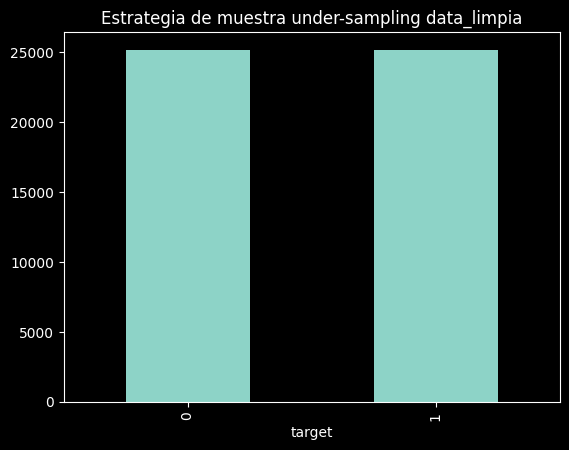

Estrategia de muestra under-sampling data_minmax
target
0    25189
1    25189
Name: count, dtype: int64


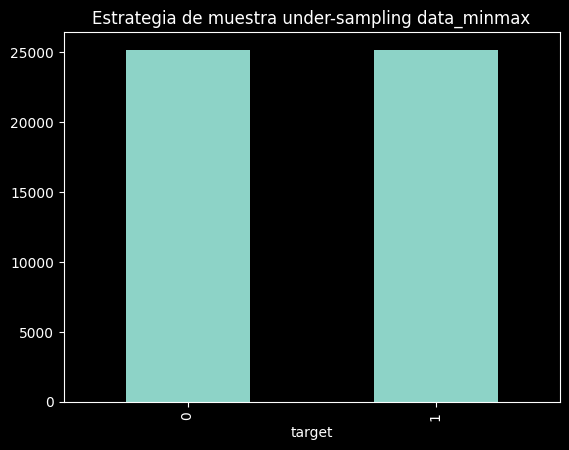

In [122]:
df_class_0_under = {}
df_train_under = {}

for key in df_class_0.keys():
    # Estrategia de undersampling para balancear la cantidad de 0 a la cantidad 1.
    df_class_0_under[key] = df_class_0[key].sample(count_class_1[key], random_state= 42)
    df_train_under[key] = pd.concat([df_class_0_under[key], df_class_1[key]], axis= 0)
    
    print(f'Estrategia de muestra under-sampling {key}')
    print(df_train_under[key]['target'].value_counts())
    df_train_under[key]['target'].value_counts().plot(kind= 'bar', title= f'Estrategia de muestra under-sampling {key}')
    plt.show()


## 9.2. Oversampling

In [123]:
# aux = df_class_1['data_limpia'].head(2)
# aux.sample(3, replace= True)

In [124]:
# df_class_1_over = {}
# df_train_over = {}

# for key in df_class_1.keys():
#     # Estrategia de oversampling para balancear la cantidad de 1 a la cantidad 0.
#     df_class_1_over[key] = df_class_1[key].sample(count_class_0[key], replace= True, random_state= 42)
#     df_train_over[key] = pd.concat([df_class_0[key], df_class_1_over[key]], axis= 0)
    
#     print(f'Estrategia de muestra over-sampling {key}')
#     print(df_train_over[key]['target'].value_counts())
#     df_train_over[key]['target'].value_counts().plot(kind= 'bar', title= f'Estrategia de muestra over-sampling {key}')
#     plt.show()

In [125]:
# for key in df_train.keys():
#     print(f'Balanceo de clases en el dataset {key}')
#     print(df_train[key]['target'].value_counts())

In [126]:
for key in df_train_under.keys():
    print(f'Balanceo de clases en el dataset {key}')
    print(df_train_under[key]['target'].value_counts())

Balanceo de clases en el dataset data_limpia
target
0    25189
1    25189
Name: count, dtype: int64
Balanceo de clases en el dataset data_minmax
target
0    25189
1    25189
Name: count, dtype: int64


In [127]:
# for key in df_train_over.keys():
#     print(f'Balanceo de clases en el dataset {key}')
#     print(df_train_over[key]['target'].value_counts())

## 9.3. Evaluación de Resultados de las Estrategias de Muestreo.


### *9.3.1. Data sin oversampling y undersampling*

In [128]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import classification_report

In [129]:
# dic_y_pred = {}

# for key in df_train.keys():
#     # Declarar el modelo.
#     model = DecisionTreeClassifier()
#     # Entrenar el modelo.
#     model.fit(dic_X_train[key], dic_y_train[key])
#     # Generar la predicción.
#     dic_y_pred[key] = model.predict(dic_X_test[key])

#     accuracy = accuracy_score(dic_y_test[key], dic_y_pred[key])
#     print(f'Accuary DATOS ORIGINALES - {key}: {accuracy * 100}')

#     ll = log_loss(dic_y_test[key], dic_y_pred[key])
#     print(f'Log Loss: {ll}')
#     print(f'The AUC score: {roc_auc_score(dic_y_test[key], dic_y_pred[key])}') 

#     print(f'Métricas de la matriz de confusión DATOS ORIGINALES - {key}:\n {classification_report(dic_y_test[key], dic_y_pred[key])}')    

### *9.3.2. Undersampling*

In [130]:
dic_cols_seleccionadas = {
    'data_limpia' : cols_X_seleccionadas,
    'data_minmax': cols_X_minmax_seleccionadas
}

In [131]:
model = DecisionTreeClassifier()
dic_X_train_u, dic_y_train_u = {}, {}
dic_y_pred_u = {}

for key in df_train_under.keys():
    dic_X_train_u[key] = df_train_under[key][dic_cols_seleccionadas[key]]
    dic_y_train_u[key] = df_train_under[key]['target']
    
    # Entrenar el modelo.
    model.fit(dic_X_train_u[key], dic_y_train_u[key])
    
    # Generar la predicción.
    dic_y_pred_u[key] = model.predict(dic_X_test[key])

    accuracy = accuracy_score(dic_y_test[key], dic_y_pred_u[key])
    print(f'Accuary DATOS UNDER-SAMPLING - {key}: {accuracy * 100}')

    ll = log_loss(dic_y_test[key], dic_y_pred_u[key])
    print(f'Log Loss: {ll}')
    print(f'The AUC score: {roc_auc_score(dic_y_test[key], dic_y_pred_u[key])}') 

    print(f'Métricas de la matriz de confusión DATOS UNDER-SAMPLING - {key}:\n {classification_report(dic_y_test[key], dic_y_pred_u[key])}')  

Accuary DATOS UNDER-SAMPLING - data_limpia: 61.02152413456232
Log Loss: 14.049266737299043
The AUC score: 0.6116945873052843
Métricas de la matriz de confusión DATOS UNDER-SAMPLING - data_limpia:
               precision    recall  f1-score   support

           0       0.98      0.61      0.75    304478
           1       0.05      0.61      0.10     10796

    accuracy                           0.61    315274
   macro avg       0.52      0.61      0.42    315274
weighted avg       0.95      0.61      0.73    315274

Accuary DATOS UNDER-SAMPLING - data_minmax: 61.93025749031001
Log Loss: 13.721726036322048
The AUC score: 0.6172034440245755
Métricas de la matriz de confusión DATOS UNDER-SAMPLING - data_minmax:
               precision    recall  f1-score   support

           0       0.98      0.62      0.76    304478
           1       0.05      0.61      0.10     10796

    accuracy                           0.62    315274
   macro avg       0.52      0.62      0.43    315274
weighte

### *9.3.3. Oversampling*

In [132]:
# model = DecisionTreeClassifier()
# dic_X_train_o, dic_y_train_o = {}, {}
# dic_y_pred_o = {}

# for key in df_train_under.keys():
#     dic_X_train_o[key] = df_train_over[key][dic_cols_seleccionadas[key]]
#     dic_y_train_o[key] = df_train_over[key]['target']
    
#     # Entrenar el modelo.
#     model.fit(dic_X_train_o[key], dic_y_train_o[key])
    
#     # Generar la predicción.
#     dic_y_pred_o[key] = model.predict(dic_X_test[key])

#     accuracy = accuracy_score(dic_y_test[key], dic_y_pred_o[key])
#     print(f'Accuary DATOS UNDER-SAMPLING - {key}: {accuracy * 100}')

#     ll = log_loss(dic_y_test[key], dic_y_pred_o[key])
#     print(f'Log Loss: {ll}')
#     print(f'The AUC score: {roc_auc_score(dic_y_test[key], dic_y_pred_o[key])}') 

#     print(f'Métricas de la matriz de confusión DATOS UNDER-SAMPLING - {key}:\n {classification_report(dic_y_test[key], dic_y_pred_o[key])}')  

**En este punto después de la evaluación observamos que es mejor trabajar con los datos undersampling por un puntaje alto en cálculo del AUC.**

# 10. Modelado

## 10.1. Data Limpia

In [133]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [134]:
modelo_1 = xgb.XGBClassifier()
modelo_2 = xgb.XGBClassifier(max_depth= 8, n_estimators= 40, learning_rate= 0.1, subsample= 0.5)

In [135]:
# # Realizamos pruebas con varios modelos y nos quedamos con la mejor métrica de AUC.
# param_grid = {
# #     'max_depth': [3, 4, 5, 6, 7, 8, 9], # Profundidad del árbol.
# #     'learning_rate': [0.1, 0.01, 0.05, 0.001], # Tasa de aprendizaje.
# #     'min_child_weight': [0.5, 0.6, 0.7], # Mínima suma de pesos en una hoja.
# #     'early_stopping_rounds': [20, 30, 40, 50],
# #     'subsample': [0.5, 0.7, 1],
#      'reg_alpha': [0.5, 0.8, 1], # Regularización L1.
#      'reg_lambda': [0.5, 0.8, 1], # Regularización L2.
    
# }

# modelo_pb = xgb.XGBClassifier(
#     min_child_weight= 0.6,
#     learning_rate= 0.1,
#     max_depth= 6
# ) 

# # Create the GridSearchCV object.
# grid_search = GridSearchCV(modelo_pb, param_grid, scoring='roc_auc')

# # Fit the GridSearchCV object to the training data.
# grid_search.fit(dic_X_train_u['data_limpia'], dic_y_train_u['data_limpia'])

# # Print the best set of hyperparameters and the corresponding score
# print("Best set of hyperparameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

In [136]:
modelo_3 = xgb.XGBClassifier(
    min_child_weight= 0.6,
    learning_rate= 0.1,
    max_depth= 5,
    reg_alpha= 1, 
    reg_lambda= 0.8
)

In [137]:
modelo_4 = xgb.XGBClassifier(
    learning_rate= 0.1,
    max_depth= 6
)

In [138]:
modelo_1.fit(dic_X_train_u['data_limpia'], dic_y_train_u['data_limpia'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [139]:
modelo_2.fit(dic_X_train_u['data_limpia'], dic_y_train_u['data_limpia'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=40, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [140]:
modelo_3.fit(dic_X_train_u['data_limpia'], dic_y_train_u['data_limpia'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=0.6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [141]:
modelo_4.fit(dic_X_train_u['data_limpia'], dic_y_train_u['data_limpia'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [142]:
# plt.figure(figsize= (12,16))
# xgb.plot_importance(modelo_3, ax= plt.gca())
# plt.plot()

In [143]:
# plt.figure(figsize= (12,16))
# xgb.plot_importance(modelo_4, ax= plt.gca())
# plt.plot()

In [144]:
pred1 = modelo_1.predict(dic_X_test['data_limpia'])
pred2 = modelo_2.predict(dic_X_test['data_limpia'])
pred3 = modelo_3.predict(dic_X_test['data_limpia'])
pred4 = modelo_4.predict(dic_X_test['data_limpia'])

In [145]:
print('AUC: ', roc_auc_score(dic_y_test['data_limpia'], pred1)) 
print(classification_report(dic_y_test['data_limpia'], pred1))

AUC:  0.7129131459097579
              precision    recall  f1-score   support

           0       0.99      0.69      0.81    304478
           1       0.08      0.74      0.14     10796

    accuracy                           0.69    315274
   macro avg       0.53      0.71      0.48    315274
weighted avg       0.96      0.69      0.79    315274



In [146]:
print('AUC: ', roc_auc_score(dic_y_test['data_limpia'], pred2)) 
print(classification_report(dic_y_test['data_limpia'], pred2))

AUC:  0.7113328673369833
              precision    recall  f1-score   support

           0       0.99      0.68      0.81    304478
           1       0.08      0.74      0.14     10796

    accuracy                           0.68    315274
   macro avg       0.53      0.71      0.47    315274
weighted avg       0.96      0.68      0.78    315274



In [147]:
print('AUC: ', roc_auc_score(dic_y_test['data_limpia'], pred3)) 
print(classification_report(dic_y_test['data_limpia'], pred3))

AUC:  0.7150100084070292
              precision    recall  f1-score   support

           0       0.99      0.69      0.81    304478
           1       0.08      0.74      0.14     10796

    accuracy                           0.69    315274
   macro avg       0.53      0.72      0.48    315274
weighted avg       0.96      0.69      0.79    315274



In [148]:
print('AUC: ', roc_auc_score(dic_y_test['data_limpia'], pred4)) 
print(classification_report(dic_y_test['data_limpia'], pred4))

AUC:  0.7146500668211576
              precision    recall  f1-score   support

           0       0.99      0.69      0.81    304478
           1       0.08      0.74      0.14     10796

    accuracy                           0.69    315274
   macro avg       0.53      0.71      0.48    315274
weighted avg       0.96      0.69      0.79    315274



## 10.2. Data MinMax

In [149]:
# modelo_1.fit(dic_X_train_u['data_minmax'], dic_y_train_u['data_minmax'])

In [150]:
# modelo_2.fit(dic_X_train_u['data_minmax'], dic_y_train_u['data_minmax'])

In [151]:
# modelo_3.fit(dic_X_train_u['data_minmax'], dic_y_train_u['data_minmax'])

In [152]:
# pred1_minmax = modelo_1.predict(dic_X_test['data_minmax'])
# pred2_minmax = modelo_2.predict(dic_X_test['data_minmax'])
# pred3_minmax = modelo_3.predict(dic_X_test['data_minmax'])

In [153]:
# print('AUC: ', roc_auc_score(dic_y_test['data_minmax'], pred1)) 
# print(classification_report(dic_y_test['data_minmax'], pred1))

In [154]:
# print('AUC: ', roc_auc_score(dic_y_test['data_minmax'], pred2)) 
# print(classification_report(dic_y_test['data_minmax'], pred2))

In [155]:
# print('AUC: ', roc_auc_score(dic_y_test['data_minmax'], pred3)) 
# print(classification_report(dic_y_test['data_minmax'], pred3))

## 10.3. Predicciones con el Test Para Enviar

In [156]:
# Creamos el envio.
submission = X_ts_5.to_pandas()[['case_id']]

In [157]:
submission_features = X_ts_5.select(pl.exclude('case_id')).to_pandas()

In [158]:
len(submission_features.columns)

55

In [159]:
# Creamos las predicciones.
predictions = modelo_4.predict(submission_features)
submission['score'] = predictions

In [160]:
submission

,case_id,score
0,57543,0
1,57549,0
2,57551,0
3,57552,0
4,57569,1
5,57630,0
6,57631,0
7,57632,0
8,57633,1
9,57634,0


In [161]:
submission.to_csv('./submission.csv', index= False)

In [162]:
df_score = pd.DataFrame(pred4)
df_score = df_score.rename(columns= {0: 'score'})

In [163]:
df_data_limpia = pd.concat([dic_X_test['data_limpia'], dic_y_test['data_limpia']], axis= 1).reset_index()

In [164]:
df_limpia_score = pd.concat([df_data_limpia, df_score], axis= 1)

In [165]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2 * roc_auc_score(x["target"], x["score"]) - 1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [166]:
stability_score_test = gini_stability(df_limpia_score)

print(f'The stability score on the test set is: {stability_score_test}')

The stability score on the test set is: 0.378700389981982
